In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

sys.dont_write_bytecode = True
from src.utils.utils import *
from src.utils.constants import *
from src.visualization.visualize import *

In [2]:
ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
ground_truth = ground_truth[['origin_time', 'label']]

In [3]:
data = {}

for exchange in EXCHANGES:
    data[(CANDLES, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{CANDLES}_pca_data.parquet'))
    data[(ORDERBOOKS, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{exchange}_{ORDERBOOKS}_pca_data.parquet'))

In [4]:
def process_dataset(param_distributions, pipeline, X, y):
    
    inner_cv = StratifiedKFold(n_splits=INNER_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        error_score='raise',
        return_train_score=True
    )
    
    randomized_search.fit(X, y)

    cv_results = pd.DataFrame(randomized_search.cv_results_)
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    best_clf = randomized_search.best_estimator_

    return cv_results, best_params, best_score, best_clf

In [7]:
# Define the SMOTE and undersampler

smote = SMOTE(random_state=RANDOM_STATE)
undersample = RandomUnderSampler(random_state=RANDOM_STATE)
smote_enn = SMOTEENN(smote=smote, random_state=RANDOM_STATE)

# Create a pipeline
pipeline = Pipeline(steps=[('smote_enn', smote_enn), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample'))])

# Define the hyperparameter search space
param_distributions = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__n_estimators': [200, 300, 400, 500],
    'classifier__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.02],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__min_samples_leaf': [5, 10, 15],
    'classifier__max_depth': [5, 10, 20, 30],
}

In [8]:
results = {}
model_data = {}

for (data_type, exchange), df in data.items():

        cols_to_drop = ['origin_time', 'label']
        merged_df = pd.merge(ground_truth[cols_to_drop], df, on='origin_time', how='inner')
        X = merged_df.drop(cols_to_drop, axis=1)
        y = merged_df['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
        cv_results, best_params, best_score, best_clf = process_dataset(param_distributions, pipeline, X_train, y_train)

        y_pred = best_clf.predict(X_test)
        evaluation = get_evaluation(y_test, y_pred)

        results[(data_type, exchange)] = {
                'cv_results': cv_results,
                'best_params': best_params,
                'best_score': best_score,
                'accuracy': evaluation['accuracy'],
                'classification_report': evaluation['classification_report'],
                'confusion_matrix': evaluation['confusion_matrix']
        }
        model_data[(data_type, exchange)] = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
        }
        pd.DataFrame.to_pickle(results[(exchange, data_type)], os.path.join(PROCESSED_DATA_PATH, f"{exchange}_{data_type}_random_forest_results.pkl"))
        pd.DataFrame.to_pickle(model_data[(exchange, data_type)], os.path.join(PROCESSED_DATA_PATH, f"{exchange}_{data_type}_random_forest_model_data.pkl"))
        pd.DataFrame.to_pickle(best_clf, os.path.join(MODELS_DATA_PATH, f'{exchange}_{data_type}_random_forest_best_clf.pkl'))

candles BINANCE


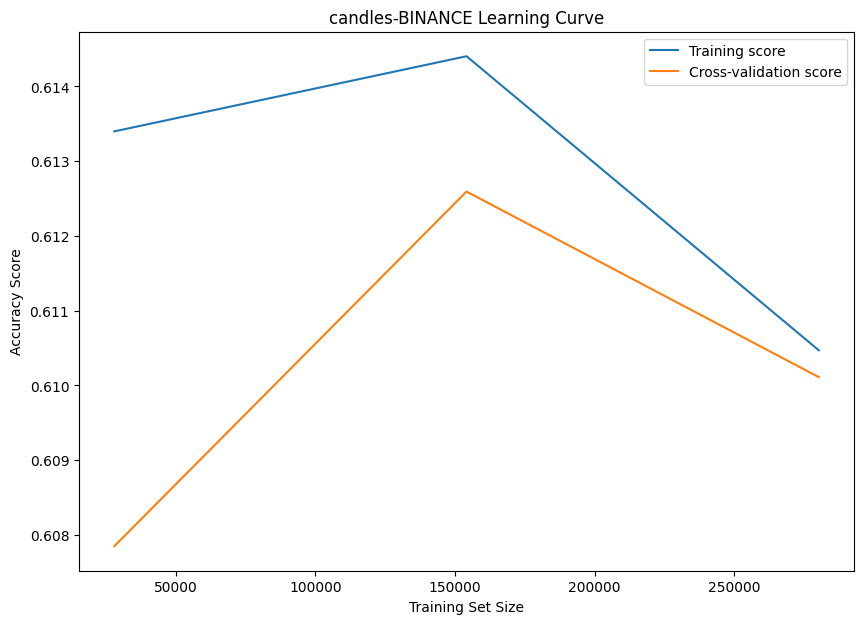

orderbooks BINANCE


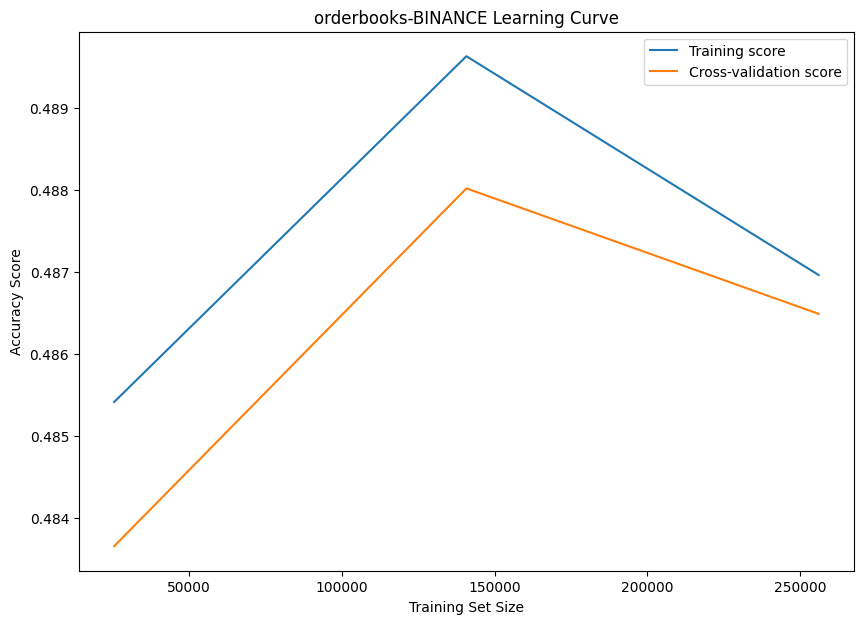

candles HUOBI


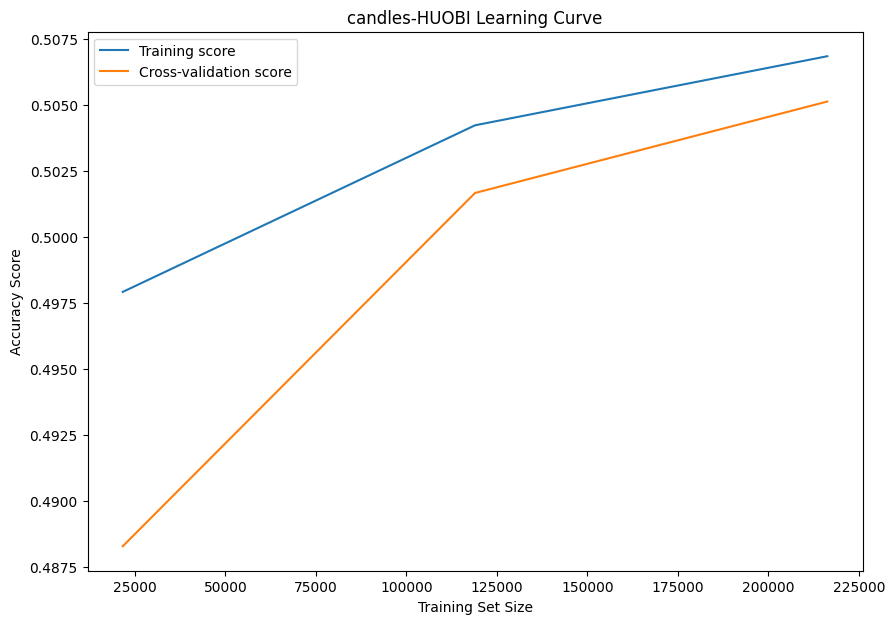

orderbooks HUOBI


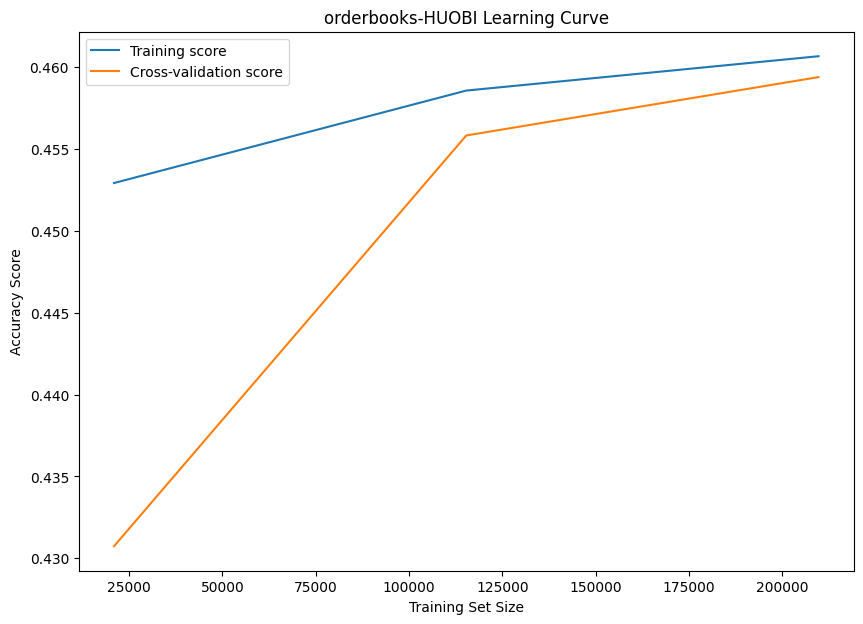

candles OKX


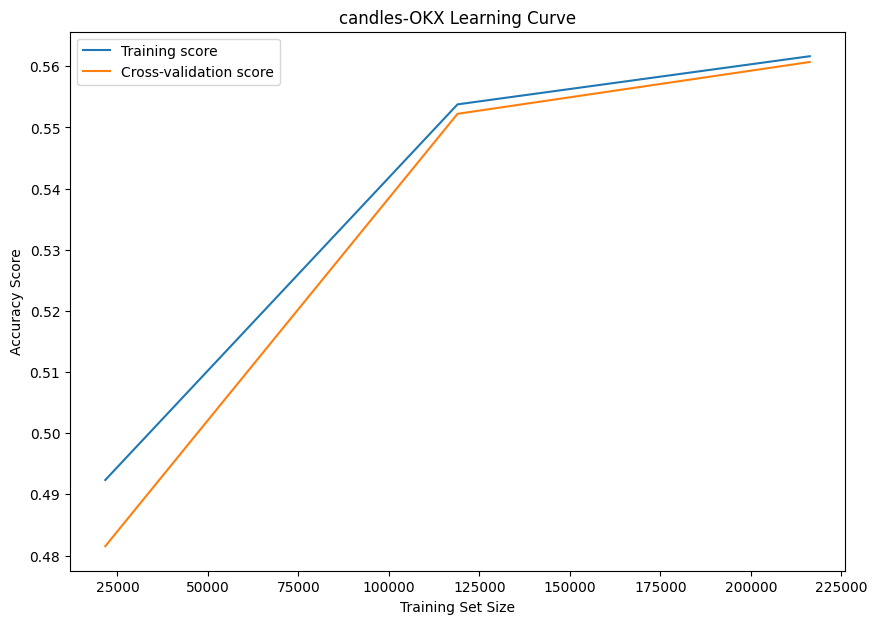

orderbooks OKX


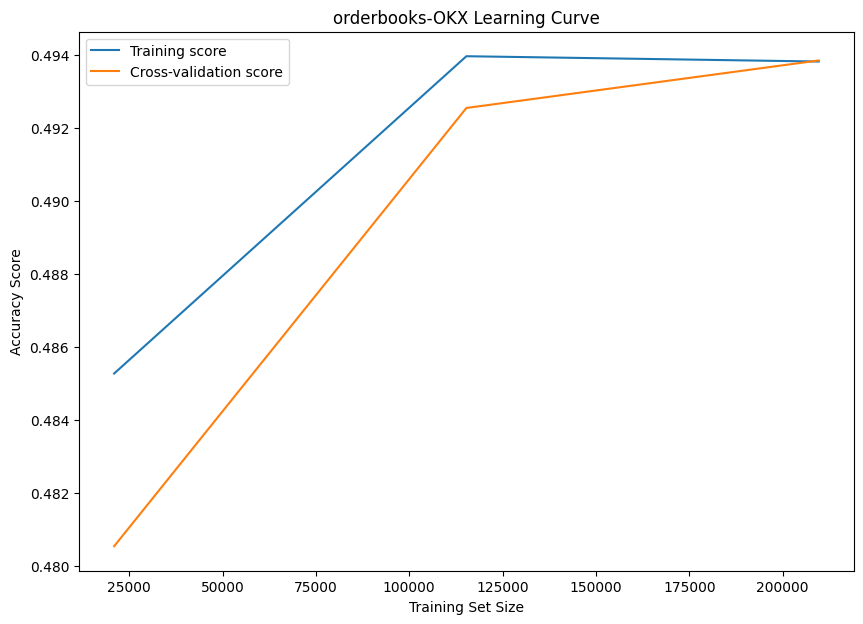

In [21]:
for (data_type, exchange), df in results.items():
    print(f'{exchange} {data_type}')
    # plot_confusion_matrix(
    #     exchange,
    #     data_type,
    #     'random_forest',
    #     df['confusion_matrix'],
    #     labels=['positive', 'neutral', 'negative']
    # )
    # path = os.path.join(MODELS_DATA_PATH, f'{data_type}_{exchange}_random_forest_best_clf.pkl')
    # print(f"Best model saved at {path}")
    best_clf = pd.read_pickle(os.path.join(MODELS_DATA_PATH, f'{data_type}_{exchange}_random_forest_best_clf.pkl'))
    plot_learning_curve(
        exchange,
        data_type,
        'random_forest',
        best_clf,
        model_data[(data_type, exchange)]['X_train'],
        model_data[(data_type, exchange)]['y_train'],
        train_sizes=np.linspace(0.1, 1.0, 3),
        cv=INNER_CV_FOLDS
    )

In [22]:
for (data_type, exchange), df in results.items():
        # Analyzing cv_results_ to check for overfitting
    cv_results = df['cv_results']
    cv_results['score_diff'] = cv_results['mean_train_score'] - cv_results['mean_test_score']
    overfitting_threshold = 0.1  # Define a threshold for overfitting
    overfitting = cv_results[cv_results['score_diff'] > overfitting_threshold]

    if not overfitting.empty:
            print("Possible overfitting detected in the following parameter combinations:")
            print(overfitting[['params', 'mean_train_score', 'mean_test_score', 'score_diff']])
    else:
            print("No significant overfitting detected.")
    display(f'{exchange} {data_type} Random Forest:\nbest score {df["best_score"]}')
    display(pd.DataFrame.from_dict(df['best_params'], orient='index').T)
    display(df['confusion_matrix'])
    display(df['classification_report'])
    display(df['cv_results'])

Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.646857   

   mean_test_score  score_diff  
6         0.513339    0.133519  


'candles BINANCE Random Forest:\nbest score 0.611069090839898'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,400,10,10,20,gini,0.02


,pred:positive,pred:neutral,pred:negative
true:positive,2581,7776,5973
true:neutral,5546,55199,11744
true:negative,2359,7663,6267


,precision,recall,f1-score,support
positive,0.246138,0.158053,0.192497,16330.000000
neutral,0.781435,0.761481,0.771329,72489.000000
negative,0.261299,0.384738,0.311226,16289.000000
accuracy,0.609345,0.609345,0.609345,0.609345
macro avg,0.429624,0.434757,0.425017,105108.000000
weighted avg,0.617662,0.609345,0.610095,105108.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,1406.568610,7.614966,2.405277,0.220972,400,30,5,30,entropy,0.01,...,0.533516,0.531708,0.003804,7,0.537818,0.526794,0.534896,0.533169,0.004663,0.001462
1,673.452306,0.910949,1.349915,0.022043,200,30,15,30,entropy,0.005,...,0.532823,0.529346,0.003017,8,0.531036,0.525624,0.534504,0.530388,0.003654,0.001042
2,913.082477,6.467759,1.430097,0.086850,400,30,15,30,gini,0.02,...,0.612777,0.611012,0.001927,2,0.610543,0.609862,0.613708,0.611371,0.001676,0.000359
3,1533.029587,6.369768,2.180902,0.105039,400,10,10,30,entropy,0.01,...,0.533223,0.533021,0.002094,4,0.538175,0.529762,0.534525,0.534154,0.003445,0.001133
4,1578.439624,5.082231,2.326262,0.074857,500,10,10,20,entropy,0.01,...,0.533309,0.532262,0.002938,5,0.537601,0.528010,0.534393,0.533335,0.003986,0.001073
5,417.178066,1.761401,1.129542,0.022111,200,10,5,10,entropy,0.01,...,0.532217,0.531896,0.003698,6,0.538282,0.527072,0.534029,0.533128,0.004621,0.001232
6,647.728564,3.213812,10.002344,0.183946,300,10,10,30,gini,0,...,0.513857,0.513339,0.002567,10,0.647459,0.646332,0.646781,0.646857,0.000463,0.133519
7,488.638738,3.002878,2.537468,0.038001,400,30,15,5,entropy,0.001,...,0.537961,0.538277,0.000293,3,0.540633,0.537758,0.539463,0.539285,0.001181,0.001007
8,832.152226,4.449283,0.986515,0.122620,400,10,10,20,gini,0.02,...,0.612962,0.611069,0.001927,1,0.610647,0.609805,0.613694,0.611382,0.001671,0.000313
9,484.441798,3.707927,1.655638,0.015443,400,20,5,10,gini,0.001,...,0.521449,0.515282,0.004369,9,0.514499,0.512840,0.523244,0.516861,0.004564,0.001579


Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.547209   

   mean_test_score  score_diff  
6         0.364992    0.182217  


'orderbooks BINANCE Random Forest:\nbest score 0.4830249807279621'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,200,30,15,30,entropy,0.005


,pred:positive,pred:neutral,pred:negative
true:positive,1847,6257,6649
true:neutral,6193,38401,21939
true:negative,1595,6312,6801


,precision,recall,f1-score,support
positive,0.191697,0.125195,0.151468,14753.000000
neutral,0.753404,0.577172,0.653617,66533.000000
negative,0.192178,0.462401,0.271513,14708.000000
accuracy,0.490124,0.490124,0.490124,0.490124
macro avg,0.379093,0.388256,0.358866,95994.000000
weighted avg,0.581087,0.490124,0.517898,95994.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,5926.672144,9.696031,1.527782,0.021338,400,30,5,30,entropy,0.01,...,0.471225,0.475644,0.003320,4,0.477733,0.479030,0.470869,0.475877,0.003581,0.000233
1,3926.682481,9.884167,0.989516,0.030275,200,30,15,30,entropy,0.005,...,0.478288,0.483025,0.003350,1,0.484124,0.488195,0.477889,0.483403,0.004238,0.000378
2,4481.382230,16.546141,0.965678,0.027826,400,30,15,30,gini,0.02,...,0.416526,0.417365,0.002107,9,0.419936,0.416444,0.415557,0.417313,0.001890,-0.000052
3,5943.147180,14.628585,1.501943,0.015038,400,10,10,30,entropy,0.01,...,0.475975,0.477499,0.002133,2,0.479784,0.478288,0.475557,0.477876,0.001750,0.000378
4,6253.823115,8.999703,1.497777,0.053495,500,10,10,20,entropy,0.01,...,0.474170,0.476173,0.001751,3,0.477233,0.478155,0.473623,0.476337,0.001955,0.000164
5,3157.779081,4.057477,0.882996,0.028862,200,10,5,10,entropy,0.01,...,0.472686,0.474272,0.002582,5,0.476565,0.474631,0.472166,0.474454,0.001800,0.000182
6,3896.182192,11.103182,11.699156,0.159869,300,10,10,30,gini,0,...,0.363976,0.364992,0.000799,10,0.548780,0.548632,0.544214,0.547209,0.002119,0.182217
7,3245.046000,7.665932,2.103221,0.048066,400,30,15,5,entropy,0.001,...,0.473381,0.471910,0.001928,7,0.472295,0.473369,0.472416,0.472694,0.000480,0.000784
8,3809.694492,7.984861,0.673340,0.057045,400,10,10,20,gini,0.02,...,0.416526,0.417438,0.002062,8,0.419964,0.416577,0.415577,0.417372,0.001877,-0.000065
9,2643.813488,1.736460,1.171635,0.022627,400,20,5,10,gini,0.001,...,0.473819,0.472337,0.001054,6,0.470627,0.475573,0.473373,0.473191,0.002023,0.000854


Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.632185   

   mean_test_score  score_diff  
6         0.491995     0.14019  


'candles HUOBI Random Forest:\nbest score 0.5049193667702323'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,400,30,15,5,entropy,0.001


,pred:positive,pred:neutral,pred:negative
true:positive,5517,3765,2932
true:neutral,17397,32177,7077
true:negative,5314,3713,3217


,precision,recall,f1-score,support
positive,0.195444,0.451695,0.272835,12214.000000
neutral,0.811424,0.567986,0.668224,56651.000000
negative,0.243233,0.262741,0.252611,12244.000000
accuracy,0.504395,0.504395,0.504395,0.504395
macro avg,0.416700,0.427474,0.397890,81109.000000
weighted avg,0.632892,0.504395,0.545944,81109.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,1035.655294,1.124068,1.542951,0.078840,400,30,5,30,entropy,0.01,...,0.496061,0.492377,0.005862,5,0.498012,0.484451,0.498118,0.493527,0.006418,0.001150
1,502.037752,2.462502,1.009761,0.035508,200,30,15,30,entropy,0.005,...,0.505465,0.501060,0.003483,2,0.500000,0.499792,0.506723,0.502171,0.003219,0.001111
2,662.707011,2.334697,0.825652,0.055011,400,30,15,30,gini,0.02,...,0.210969,0.210485,0.000665,9,0.210146,0.210872,0.210719,0.210579,0.000312,0.000094
3,1085.743365,3.448449,1.518780,0.049673,400,10,10,30,entropy,0.01,...,0.495377,0.492495,0.005929,4,0.498289,0.484368,0.497152,0.493270,0.006312,0.000775
4,1190.300589,1.948903,1.521447,0.076355,500,10,10,20,entropy,0.01,...,0.492233,0.492331,0.005572,6,0.499695,0.485112,0.493846,0.492884,0.005992,0.000553
5,322.290608,0.586189,0.841988,0.039759,200,10,5,10,entropy,0.01,...,0.495210,0.492720,0.005916,3,0.498821,0.484493,0.496445,0.493253,0.006270,0.000533
6,478.876487,1.538932,7.103644,0.091050,300,10,10,30,gini,0,...,0.492917,0.491995,0.001310,7,0.631829,0.632476,0.632250,0.632185,0.000268,0.140190
7,372.781753,1.893745,1.918854,0.062669,400,30,15,5,entropy,0.001,...,0.506926,0.504919,0.004492,1,0.510634,0.499061,0.509363,0.506353,0.005182,0.001433
8,634.509024,1.583860,0.464586,0.029774,400,10,10,20,gini,0.02,...,0.210969,0.210485,0.000665,9,0.210146,0.210872,0.210719,0.210579,0.000312,0.000094
9,355.909308,1.078300,1.330912,0.005250,400,20,5,10,gini,0.001,...,0.488663,0.486811,0.001310,8,0.488839,0.486874,0.490896,0.488870,0.001642,0.002059


Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.548072   

   mean_test_score  score_diff  
6         0.369224    0.178849  


'orderbooks HUOBI Random Forest:\nbest score 0.4541375712245374'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,400,20,5,10,gini,0.001


,pred:positive,pred:neutral,pred:negative
true:positive,4887,4575,2644
true:neutral,16452,29544,8389
true:negative,4786,4639,2708


,precision,recall,f1-score,support
positive,0.187062,0.403684,0.255656,12106.000000
neutral,0.762268,0.543238,0.634379,54385.000000
negative,0.197074,0.223193,0.209322,12133.000000
accuracy,0.472362,0.472362,0.472362,0.472362
macro avg,0.382135,0.390038,0.366453,78624.000000
weighted avg,0.586483,0.472362,0.510473,78624.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,4211.504738,2.377711,1.066363,0.005391,400,30,5,30,entropy,0.01,...,0.430703,0.432290,0.005795,5,0.424772,0.437912,0.434657,0.432447,0.005587,0.000157
1,2740.442426,7.370226,0.758306,0.019674,200,30,15,30,entropy,0.005,...,0.446299,0.445104,0.004615,2,0.439257,0.450046,0.451389,0.446897,0.005430,0.001793
2,3106.235223,7.396847,0.706130,0.010979,400,30,15,30,gini,0.02,...,0.187664,0.188324,0.000598,9,0.188388,0.187954,0.188688,0.188343,0.000301,0.000019
3,4204.448936,20.579125,1.081366,0.052183,400,10,10,30,entropy,0.01,...,0.433154,0.431190,0.008169,6,0.419526,0.437545,0.437948,0.431673,0.008591,0.000483
4,4466.930514,8.713958,1.002685,0.027322,500,10,10,20,entropy,0.01,...,0.432811,0.430007,0.007499,7,0.418939,0.435198,0.437562,0.430566,0.008278,0.000560
5,2180.287615,4.217839,0.599944,0.021383,200,10,5,10,entropy,0.01,...,0.435491,0.434799,0.004858,4,0.426713,0.438222,0.439756,0.434897,0.005821,0.000099
6,2707.049768,9.165088,8.718608,0.076566,300,10,10,30,gini,0,...,0.367162,0.369224,0.002153,8,0.546615,0.550064,0.547538,0.548072,0.001458,0.178849
7,2240.842951,2.913604,1.656472,0.039128,400,30,15,5,entropy,0.001,...,0.438859,0.439918,0.002431,3,0.436763,0.445186,0.444425,0.442125,0.003804,0.002207
8,2672.036310,3.977983,0.435747,0.014820,400,10,10,20,gini,0.02,...,0.187664,0.188324,0.000598,9,0.188388,0.187954,0.188688,0.188343,0.000301,0.000019
9,1815.951754,2.964389,1.029690,0.021525,400,20,5,10,gini,0.001,...,0.449600,0.454138,0.003417,1,0.455698,0.458989,0.453516,0.456068,0.002250,0.001930


Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.637965   

   mean_test_score  score_diff  
6         0.500912    0.137052  


'candles OKX Random Forest:\nbest score 0.5633240954766027'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,400,30,15,5,entropy,0.001


,pred:positive,pred:neutral,pred:negative
true:positive,4952,4413,2849
true:neutral,11772,37849,7032
true:negative,4648,4374,3222


,precision,recall,f1-score,support
positive,0.231705,0.405436,0.294885,12214.000000
neutral,0.811583,0.668085,0.732876,56653.000000
negative,0.245898,0.263149,0.254231,12244.000000
accuracy,0.567408,0.567408,0.567408,0.567408
macro avg,0.429729,0.445557,0.427331,81111.000000
weighted avg,0.638871,0.567408,0.594668,81111.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,1060.888663,1.187672,1.698312,0.057999,400,30,5,30,entropy,0.01,...,0.546127,0.548758,0.003279,3,0.552646,0.549208,0.546897,0.549584,0.002362,0.000826
1,512.213301,1.710957,1.059863,0.037695,200,30,15,30,entropy,0.005,...,0.531795,0.535661,0.004188,6,0.540995,0.536545,0.534090,0.537210,0.002858,0.001549
2,670.543836,4.289179,0.856325,0.005544,400,30,15,30,gini,0.02,...,0.347462,0.338036,0.006695,9,0.332742,0.333119,0.349070,0.338310,0.007610,0.000274
3,1108.063029,6.194006,1.647638,0.038003,400,10,10,30,entropy,0.01,...,0.548402,0.548492,0.002234,4,0.550117,0.548436,0.548358,0.548970,0.000811,0.000478
4,1196.024586,1.669341,1.664973,0.079442,500,10,10,20,entropy,0.01,...,0.550491,0.550212,0.004419,2,0.554551,0.547636,0.551104,0.551097,0.002823,0.000885
5,320.879847,0.923256,0.858325,0.046931,200,10,5,10,entropy,0.01,...,0.547024,0.547213,0.001898,5,0.548591,0.547271,0.548566,0.548143,0.000616,0.000929
6,487.051495,1.982548,7.160321,0.103073,300,10,10,30,gini,0,...,0.499607,0.500912,0.001240,8,0.637073,0.637962,0.638859,0.637965,0.000729,0.137052
7,370.248620,1.781820,1.703647,0.005950,400,30,15,5,entropy,0.001,...,0.561171,0.563324,0.002705,1,0.567385,0.564511,0.561095,0.564330,0.002571,0.001006
8,631.930549,0.891294,0.546268,0.053833,400,10,10,20,gini,0.02,...,0.347462,0.338023,0.006703,10,0.332728,0.333110,0.349070,0.338302,0.007615,0.000279
9,352.288640,0.372361,1.264400,0.009492,400,20,5,10,gini,0.001,...,0.530029,0.531063,0.000924,7,0.532363,0.533290,0.532033,0.532562,0.000532,0.001500


Possible overfitting detected in the following parameter combinations:
                                              params  mean_train_score  \
6  {'classifier__n_estimators': 300, 'classifier_...          0.488106   

   mean_test_score  score_diff  
6         0.310386     0.17772  


'orderbooks OKX Random Forest:\nbest score 0.4913273863763969'

,classifier__n_estimators,classifier__min_samples_split,classifier__min_samples_leaf,classifier__max_depth,classifier__criterion,classifier__ccp_alpha
0,400,10,10,30,entropy,0.01


,pred:positive,pred:neutral,pred:negative
true:positive,1027,5913,5166
true:neutral,3728,32706,17951
true:negative,994,5843,5296


,precision,recall,f1-score,support
positive,0.178640,0.084834,0.115038,12106.000000
neutral,0.735594,0.601379,0.661750,54385.000000
negative,0.186394,0.436496,0.261234,12133.000000
accuracy,0.496401,0.496401,0.496401,0.496401
macro avg,0.366876,0.374236,0.346007,78624.000000
weighted avg,0.565087,0.496401,0.515765,78624.000000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,param_classifier__ccp_alpha,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
0,4582.904736,13.254931,1.326245,0.003342,400,30,5,30,entropy,0.01,...,0.499022,0.488586,0.013144,4,0.494928,0.472387,0.499547,0.488954,0.011866,0.000367
1,2922.142104,5.075201,0.891831,0.012347,200,30,15,30,entropy,0.005,...,0.479572,0.471394,0.005783,5,0.466444,0.469687,0.478995,0.471709,0.005320,0.000315
2,3382.411159,11.725282,0.806482,0.011035,400,30,15,30,gini,0.02,...,0.427059,0.407647,0.013752,8,0.396889,0.400548,0.425729,0.407722,0.012820,0.000075
3,4580.767008,5.627330,1.362751,0.007650,400,10,10,30,entropy,0.01,...,0.497706,0.491327,0.013322,1,0.502211,0.475172,0.497963,0.491782,0.011872,0.000455
4,4813.128363,7.001337,1.448933,0.029052,500,10,10,20,entropy,0.01,...,0.499633,0.489200,0.012073,3,0.493888,0.474743,0.499952,0.489528,0.010744,0.000327
5,2250.258687,4.122361,0.827153,0.115326,200,10,5,10,entropy,0.01,...,0.504192,0.489687,0.013498,2,0.492009,0.474027,0.504727,0.490254,0.012594,0.000568
6,2907.978492,5.297685,9.028165,0.373440,300,10,10,30,gini,0,...,0.309136,0.310386,0.000913,10,0.488393,0.489986,0.485939,0.488106,0.001665,0.177720
7,2317.125853,5.888452,1.710982,0.021069,400,30,15,5,entropy,0.001,...,0.446557,0.440697,0.006416,7,0.444294,0.435132,0.447144,0.442190,0.005125,0.001493
8,2871.937345,3.393413,0.493758,0.023824,400,10,10,20,gini,0.02,...,0.427059,0.407647,0.013752,8,0.396889,0.400548,0.425729,0.407722,0.012820,0.000075
9,1927.532500,4.829710,1.087200,0.012658,400,20,5,10,gini,0.001,...,0.452872,0.445928,0.006241,6,0.447461,0.442167,0.452987,0.447538,0.004418,0.001610
